In [208]:
import matplotlib.pyplot as plt
import json

## Data

The data below was collected from DraftKings and then converted to implied probabilities using: https://www.gamingtoday.com/tools/implied-probability/


In [209]:
with open("../data/odds/championship_odds.json", "r") as f:
    data = json.load(f)

### Basic: y = mx + b

In [210]:
import numpy as np
from statistics import mean

def slope_intercept(team):
    xs, ys = np.array([float(k) for k in team.keys()]), np.array([v[1] for v in team.values()])
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b

m_b = {
    "chiefs": slope_intercept(data["chiefs"]),
    "ravens": slope_intercept(data["ravens"]),
    "niners": slope_intercept(data["niners"]),
    "lions": slope_intercept(data["lions"])
}


In [211]:
def rnd(v):
    return round(v, 4)


def x_intercept(m, b):
    return -b/m

print(f"Chiefs: m = {rnd(m_b['chiefs'][0])} b = {rnd(m_b['chiefs'][1])} x-intercept = {rnd(x_intercept(*m_b['chiefs']))}")
print(f"Ravens: m = {rnd(m_b['ravens'][0])} b = {rnd(m_b['ravens'][1])} x-intercept = {rnd(x_intercept(*m_b['ravens']))}")
print(f"Niners: m = {rnd(m_b['niners'][0])} b = {rnd(m_b['niners'][1])} x-intercept = {rnd(x_intercept(*m_b['niners']))}")
print(f"Lions:  m = {rnd(m_b['lions'][0])} b = {rnd(m_b['lions'][1])} x-intercept = {rnd(x_intercept(*m_b['lions']))}")


Chiefs: m = 0.0386 b = -0.2739 x-intercept = 7.0968
Ravens: m = 0.0389 b = -0.4103 x-intercept = 10.543
Niners: m = 0.0374 b = -0.5688 x-intercept = 15.2006
Lions:  m = 0.0384 b = -0.3123 x-intercept = 8.1241


<Figure size 640x480 with 0 Axes>

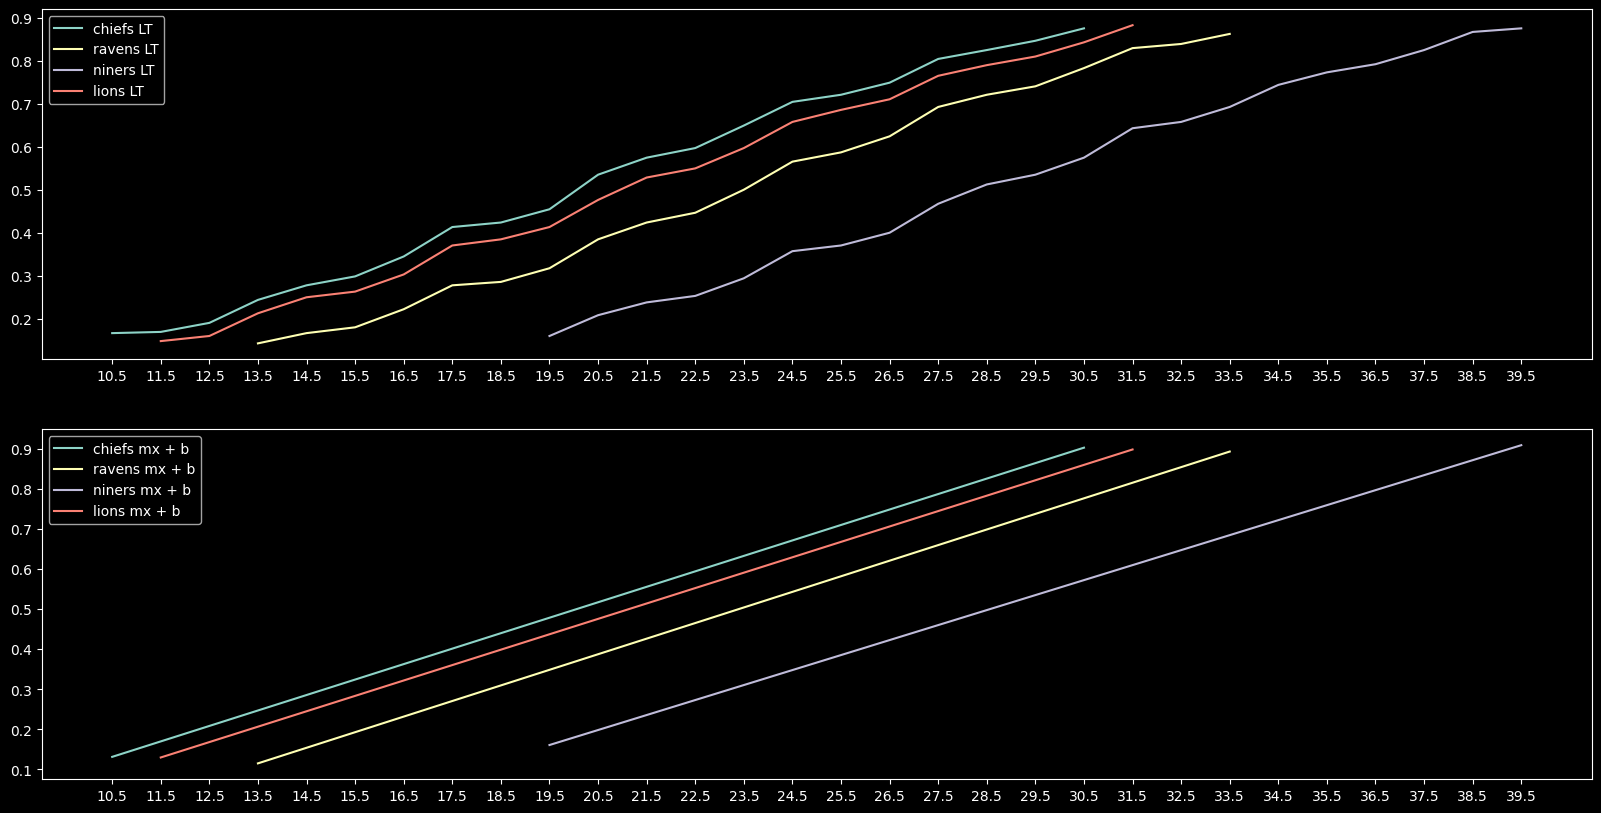

In [212]:
def get_mx_b(m, b, x_vals):
    return [(m*x)+b for x in x_vals]
fig = plt.figure()
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
for team in ("chiefs", "ravens", "niners", "lions"):
    ax[0].plot(data[team].keys(), [v[1] for v in data[team].values()], label=f"{team} LT")
    ax[1].plot(data[team].keys(), get_mx_b(*m_b[team], [float(k) for k in data[team].keys()]), label=f"{team} mx + b")
ax[0].legend()
ax[1].legend()
plt.show()

## Next Step: CMFs, CDFs, and PDFs

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline, Akima1DInterpolator

def get_cdf_model(team:dict, interpolation_type:str, inverse:bool = False):
    """Build a CDF model from the implied probability of team total odds
    """
    # Removing the "Sportsbook Edge" to get a true probability
    data_less_than = [((float(k)), v[1] - ((v[0] + v[1] - 1) / 2)) for (k,v) in team.items()]
    max_pts, max_offset = max([point[0] for point in data_less_than]), 10

    # Build the CDF from the data
    points         = np.array([0] + [point[0] for point in data_less_than] + [max_pts + max_offset])
    prob_less_than = np.array([0] + [point[1] for point in data_less_than] + [1])
    
    X = prob_less_than if inverse else points
    Y = points if inverse else prob_less_than
    # Choose interpolation method for the CDF
    if interpolation_type in ("linear", "quadratic", "cubic"):
        return interp1d(X, Y, kind=interpolation_type, fill_value=(0, 1), bounds_error=False)
    if interpolation_type == "cubic_spline":
        return CubicSpline(X, Y, bc_type='clamped')
    if interpolation_type == "akima":
        return Akima1DInterpolator(X, Y)

chiefs_models   = {t: get_cdf_model(data["chiefs"], t) for t in ["linear", "quadratic", "cubic", "cubic_spline", "akima"]} 
chiefs_inv_models   = {t: get_cdf_model(data["chiefs"], t, inverse=True) for t in ["linear", "quadratic", "cubic"]}
ravens_models   = {t: get_cdf_model(data["ravens"], t, inverse=False) for t in ["linear", "quadratic", "cubic"]}
ravens_inv_models   = {t: get_cdf_model(data["ravens"], t, inverse=True) for t in ["linear", "quadratic", "cubic"]}

models = {
    "chiefs": chiefs_models,
    "ravens": ravens_models
}
inv_models = {
    "chiefs": chiefs_inv_models,
    "ravens": ravens_inv_models
}



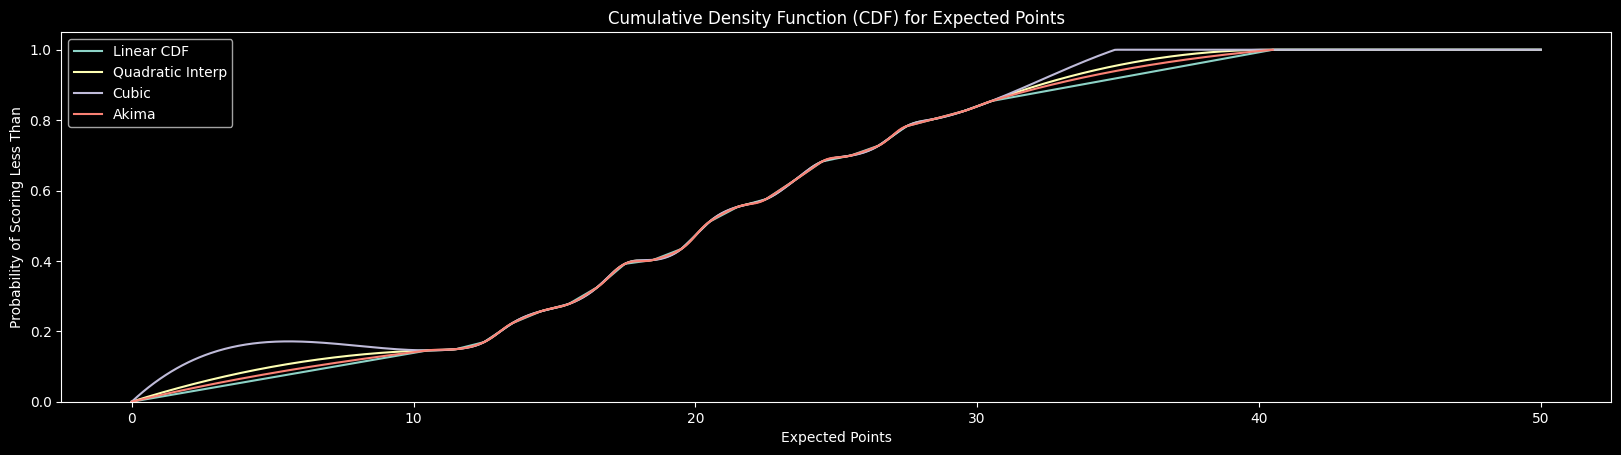

In [222]:
x_high_res      = np.linspace(0, 50, 1000)
linear_vals     = np.clip(chiefs_models["linear"](x_high_res), 0, 1)
quadratic_vals  = np.clip(chiefs_models["quadratic"](x_high_res), 0, 1)
cubic_vals      = np.clip(chiefs_models["cubic"](x_high_res), 0, 1)
cs_vals         = np.clip(chiefs_models["cubic_spline"](x_high_res), 0, 1)
akima_vals      = np.clip(chiefs_models["akima"](x_high_res), 0, 1)

# Plot the PDF
fig = plt.figure()
fig.set_figwidth(20)
plt.plot(x_high_res, linear_vals, label='Linear CDF')
plt.plot(x_high_res, quadratic_vals, label='Quadratic Interp')
plt.plot(x_high_res, cubic_vals, label='Cubic')
plt.plot(x_high_res, akima_vals, label='Akima')
plt.ylim(bottom=0, top=1.05)
plt.xlabel('Expected Points')
plt.ylabel('Probability of Scoring Less Than')
plt.title('Cumulative Density Function (CDF) for Expected Points')
plt.legend()
plt.show()

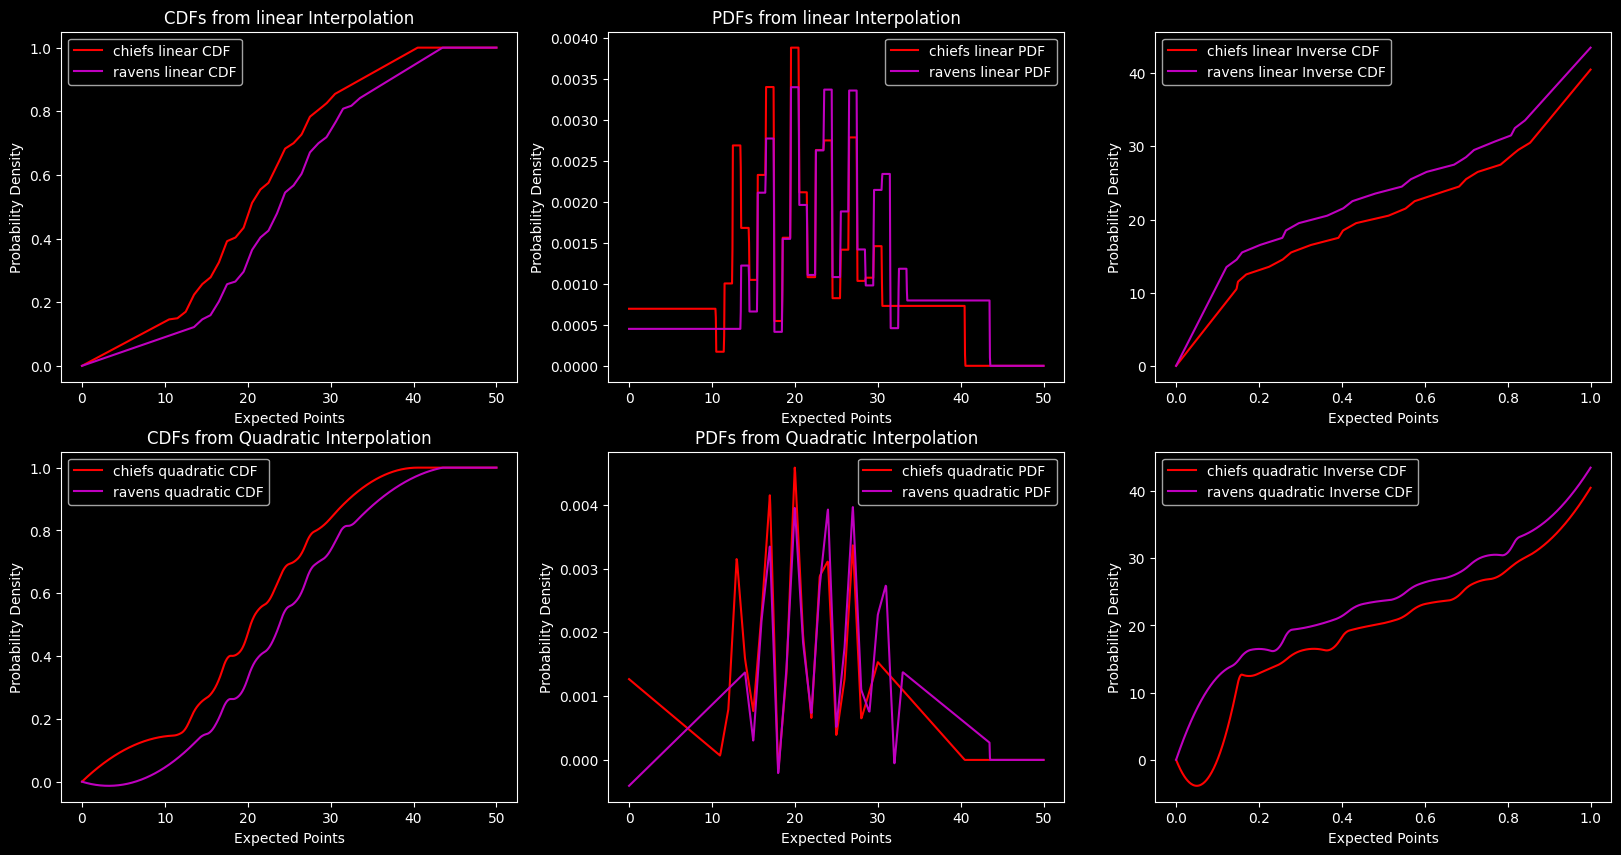

In [223]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a high-resolution x-axis range
x_high_res = np.linspace(0, 50, 1000)


# Plot the PDFs
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0][0].set_title("CDFs from linear Interpolation")
ax[0][1].set_title("PDFs from linear Interpolation")
ax[1][0].set_title("CDFs from Quadratic Interpolation")
ax[1][1].set_title("PDFs from Quadratic Interpolation")
for team, color in (("chiefs", 'r'), ("ravens", 'm')):
    for i, model in enumerate(["linear", "quadratic"]):
        team_cdf = models[team][model](x_high_res)
        ax[i][0].plot(x_high_res, team_cdf, color, label=f"{team} {model} CDF")
        ax[i][1].plot(x_high_res[:-1], np.diff(team_cdf), color, label=f"{team} {model} PDF")
        ax[i][2].plot(np.linspace(0, 1, 1000), inv_models[team][model](np.linspace(0, 1, 1000)), color, label=f"{team} {model} Inverse CDF")
[a.legend() for a in ax.flatten()]
[a.set_xlabel('Expected Points') for a in ax.flatten()]
[a.set_ylabel('Probability Density') for a in ax.flatten()]
plt.show()


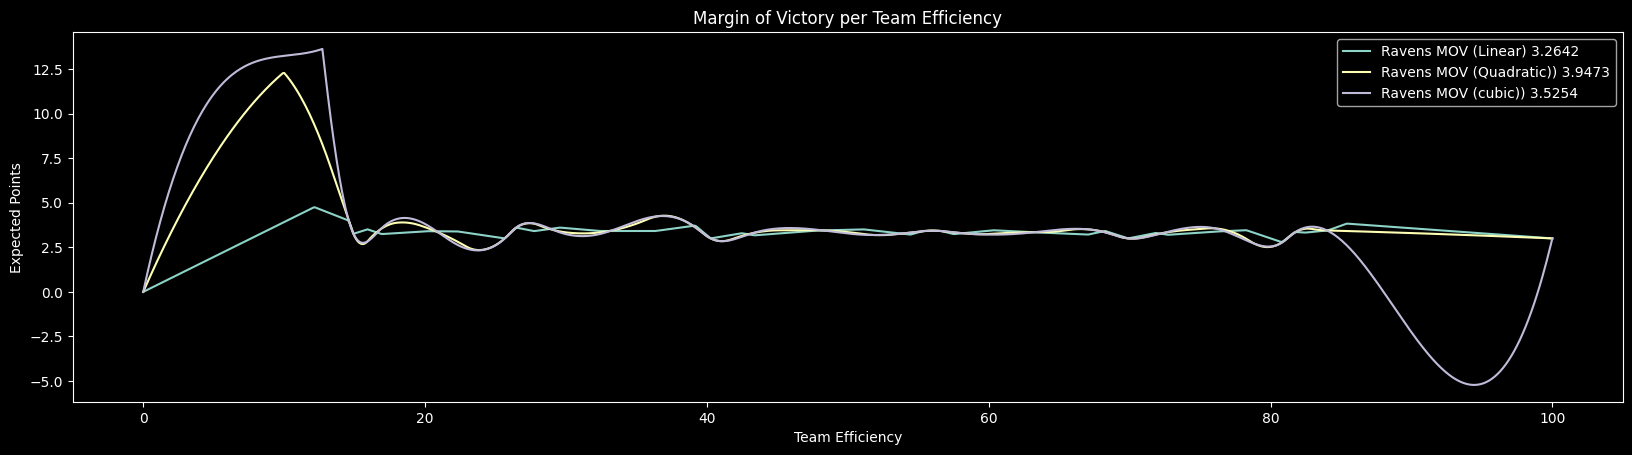

In [224]:
zero_to_one          =    np.linspace(0, 1, 1000)

def margin_of_victory(team1_model, team2_model, efficiency):
    return np.clip(team1_model(efficiency), 0, 100) - np.clip(team2_model(efficiency), 0, 100)

mov_linear      = ([margin_of_victory(ravens_inv_models["linear"], chiefs_inv_models["linear"], p) for p in zero_to_one])
mov_quadratic   = ([margin_of_victory(ravens_inv_models["quadratic"], chiefs_inv_models["quadratic"], p) for p in zero_to_one])
mov_cubic       = ([margin_of_victory(ravens_inv_models["cubic"], chiefs_inv_models["cubic"], p) for p in zero_to_one])

# Plot the PDF
fig = plt.figure()
fig.set_figwidth(20)
plt.plot([r*100 for r in zero_to_one], mov_linear, label=f'Ravens MOV (Linear) {rnd(sum(mov_linear) / len(mov_linear))}')
plt.plot([r*100 for r in zero_to_one], mov_quadratic, label=f'Ravens MOV (Quadratic)) {rnd(sum(mov_quadratic) / len(mov_quadratic))}')
plt.plot([r*100 for r in zero_to_one], mov_cubic, label=f'Ravens MOV (cubic)) {rnd(sum(mov_cubic) / len(mov_cubic))}')
plt.xlabel('Team Efficiency')
plt.ylabel('Expected Points')
plt.title('Margin of Victory per Team Efficiency')
plt.legend()
plt.show()


In [ ]:
# Build probability distribution from this margin of victory


## The "House Edge"

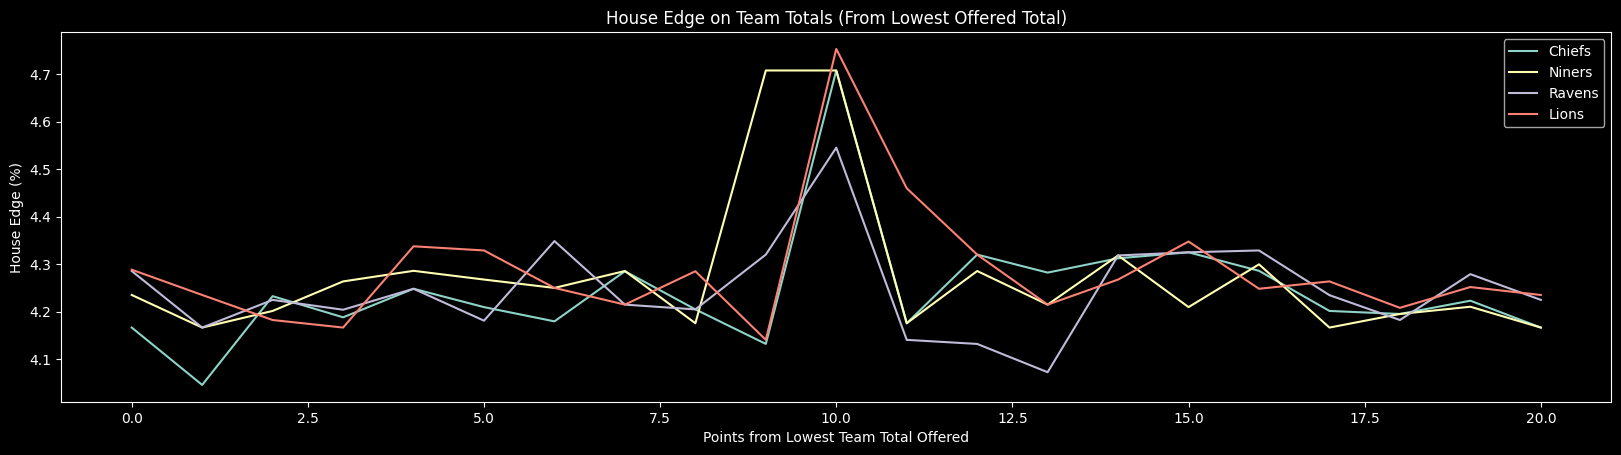

In [216]:
fig = plt.figure()
fig.set_figwidth(20)
plt.plot(range(len(data["chiefs"].values())), [(v[0] + v[1]-1)*100 for v in data["chiefs"].values()], label="Chiefs")
plt.plot(range(len(data["niners"].values())), [(v[0] + v[1]-1)*100 for v in data["niners"].values()], label="Niners")
plt.plot(range(len(data["ravens"].values())), [(v[0] + v[1]-1)*100 for v in data["ravens"].values()], label="Ravens")
plt.plot(range(len(data["lions"].values())),  [(v[0] + v[1]-1)*100 for v in data["lions"].values()],  label="Lions")
plt.legend()
plt.ylabel("House Edge (%)")
plt.xlabel("Points from Lowest Team Total Offered")
plt.title("House Edge on Team Totals (From Lowest Offered Total)")
plt.show()

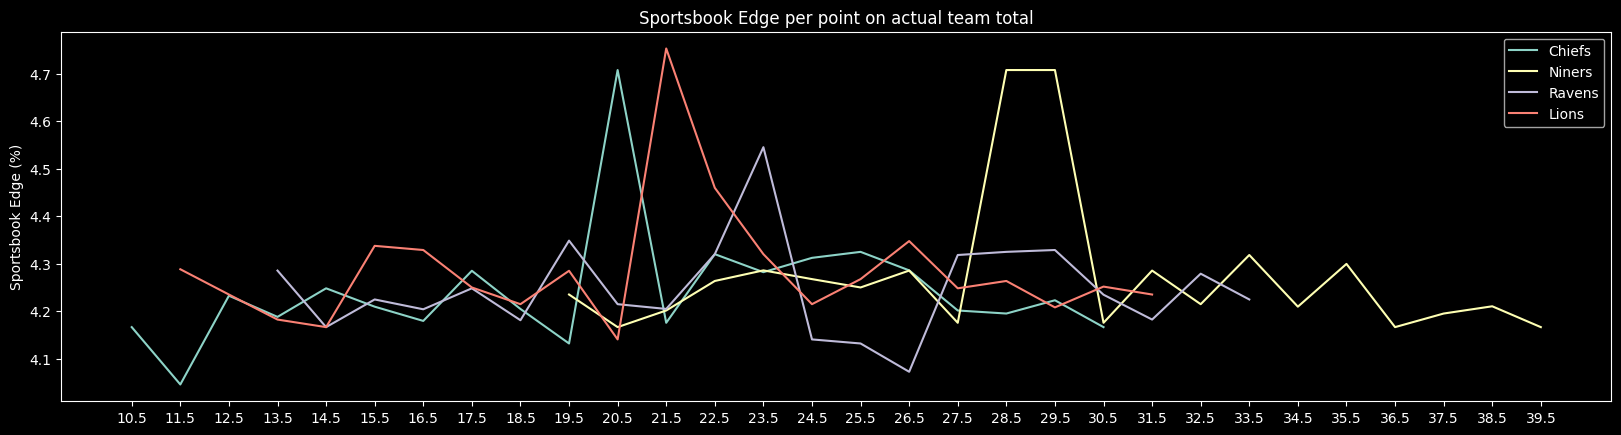

In [217]:
fig = plt.figure()
fig.set_figwidth(20)
plt.plot(data["chiefs"].keys(), [((v[0] + v[1])-1)*100 for v in data["chiefs"].values()], label="Chiefs")
plt.plot(data["niners"].keys(), [((v[0] + v[1])-1)*100 for v in data["niners"].values()], label="Niners")
plt.plot(data["ravens"].keys(), [((v[0] + v[1])-1)*100 for v in data["ravens"].values()], label="Ravens")
plt.plot(data["lions"].keys(),  [((v[0] + v[1])-1)*100 for v in data["lions"].values()], label="Lions")
plt.legend()
plt.ylabel("Sportsbook Edge (%)")
plt.title("Sportsbook Edge per point on actual team total")
plt.show()